# Check Juila Version

In [1]:
versioninfo()

Julia Version 1.8.3
Commit 0434deb161e (2022-11-14 20:14 UTC)
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 8 × Intel(R) Core(TM) i7-4790K CPU @ 4.00GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-13.0.1 (ORCJIT, haswell)
  Threads: 1 on 8 virtual cores


# Install required packages

In [2]:
using Pkg
Pkg.add(["ZipFile", "Random", "Augmentor", "Images", "MLUtils", "Flux", "ImageCore", "OneHotArrays"])

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/julia-projects/image-class-article/Project.toml`
  No Changes to `~/julia-projects/image-class-article/Manifest.toml`


# Set random seed

In [3]:
using Random
seed = 12
Random.Random.seed!(seed)

TaskLocalRNG()

# Download and extract image files to local storage

In [4]:
download("https://github.com/thetestspecimen/notebooks/raw/main/datasets/rock_paper_scissors/rock_paper_scissors.zip","./rock_paper_scissors.zip")

"./rock_paper_scissors.zip"

The following function unzips the image files into a folder structure.

Source code for this function (with a minor adjustment to check subfolders): https://github.com/sylvaticus/LAJuliaUtils.jl

In [5]:
using ZipFile
function unzip_file(file,exdir="")
    fileFullPath = isabspath(file) ?  file : joinpath(pwd(),file)
    basePath = dirname(fileFullPath)
    outPath = (exdir == "" ? basePath : (isabspath(exdir) ? exdir : joinpath(pwd(),exdir)))
    isdir(outPath) || mkdir(outPath)
    zarchive = ZipFile.Reader(fileFullPath)
    for f in zarchive.files
        fullFilePath = joinpath(outPath,f.name)
        if (endswith(f.name,"/") || endswith(f.name,"\\"))
            isdir(fullFilePath) ||  mkdir(fullFilePath)
        else
            write(fullFilePath, read(f))
        end
    end
    close(zarchive)
end

unzip_file (generic function with 2 methods)

In [6]:
root_folder = "rps"
unzip_file("rock_paper_scissors.zip", root_folder)

# A view of the new directory structure and files

In [7]:
for (root, dirs, files) in walkdir("rps")
    println("$(length(dirs)) directories and $(length(files)) files in $root")
end

3 directories and 0 files in rps
0 directories and 200 files in rps/paper
0 directories and 200 files in rps/rock
0 directories and 200 files in rps/scissors


In [8]:
readdir(root_folder)

3-element Vector{String}:
 "paper"
 "rock"
 "scissors"

# Plot an example image from each class

In [9]:
using Images, ImageCore
function plot_example_image(root_f, target_class)
    # target directory
    target_folder = "$(root_f)/$(target_class)/"
    # random image
    image_name = Random.rand(readdir(target_folder))
    # plot image
    img = Images.load(string(target_folder, image_name))
    img_channels = ImageCore.channelview(float32.(img))
    println("Type: ", typeof(img))
    println("Shape: ", size(img))
    println("Colour channels: ", size(img_channels)[1])
    println("Size: ", sizeof(img)/1000," KB")
    println("Max: ", maximum(img_channels))
    println("Min: ", minimum(img_channels))
    println("Image name: ", image_name)
    println("Class: ", target_class)
    return img
end

plot_example_image (generic function with 1 method)

Type: Matrix{RGB{N0f8}}
Shape: (200, 300)
Colour channels: 3
Size: 180.0 KB
Max: 0.96862745
Min: 0.0
Image name: BnnRzew7yA30gyts.png
Class: rock


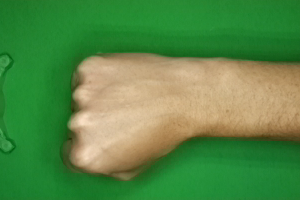

In [10]:
plot_example_image(root_folder,"rock")

Type: Matrix{RGB{N0f8}}
Shape: (200, 300)
Colour channels: 3
Size: 180.0 KB
Max: 0.84313726
Min: 0.0
Image name: AjwddXm0ttm7Ts5J.png
Class: paper


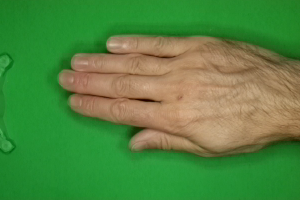

In [11]:
plot_example_image(root_folder,"paper")

Type: Matrix{RGB{N0f8}}
Shape: (200, 300)
Colour channels: 3
Size: 180.0 KB
Max: 0.88235295
Min: 0.0
Image name: asi6ZQCskd51eHm1.png
Class: scissors


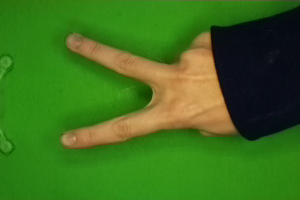

In [12]:
plot_example_image(root_folder,"scissors")

# Load Images and Labels

In [13]:
using Random, Images
function get_images_and_labels(root_dir::String, image_size::Tuple{Int,Int}, shuffle_data::Bool, val_split::Float64, seed::Int=42)

    # initialise storage arrays
    label_categ = String[]
    image_paths = String[]
    labels = String[]

    # get image paths and labels
    for (index, (root, dirs, files)) in enumerate(walkdir(root_dir))
        (root == root_dir) && (label_categ = dirs)
        if index > 1
            new_images = map(x -> (root_dir * label_categ[index-1] * '/' * x), files)
            new_labels = repeat([label_categ[index-1]], length(files))
            image_paths = vcat(image_paths, new_images)
            labels = vcat(labels, new_labels)
        end
    end

    # load and scale images
    imgs = Images.load.(image_paths)
    # note: image_size is expected in the format (height, width)
    imgs = map(image -> Images.imresize(image, image_size), imgs)
    all_data = hcat(imgs, labels)

    # shuffle data
    Random.Random.seed!(seed)
    shuffle_data && (all_data = all_data[Random.shuffle(begin:end),:])

    # train / val split
    split_index = trunc(Int, (size(all_data)[1] * val_split))
    train = all_data[split_index+1:end,:]
    val = all_data[begin:split_index,:]

    return train[:,begin], train[:,end], val[:,begin], val[:,end], label_categ
end

get_images_and_labels (generic function with 2 methods)

In [14]:
IMAGE_HEIGHT = 160
IMAGE_WIDTH = 160
IMAGE_SIZE = (IMAGE_HEIGHT,IMAGE_WIDTH)
BATCH_SIZE = 32

X_train, y_train, X_val, y_val, categories = get_images_and_labels("$(root_folder)/", IMAGE_SIZE, true, 0.2, seed);

The dimensions of each array of data (i.e. the amount of sample in each array)

In [15]:
size(X_train), size(y_train), size(X_val), size(y_val)

((480,), (480,), (120,), (120,))

A sample output image:

Image dimensions: (160, 160)
Label: scissors



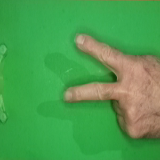

In [16]:
sample_number = 12 # must be less than the length of X_train, which in this case is 480 
println("Image dimensions: $(size(X_train[sample_number]))")
println("Label: $(y_train[sample_number])")
println()
ImageCore.colorview(RGB, X_train[sample_number])

All the categories available:

In [17]:
categories

3-element Vector{String}:
 "paper"
 "rock"
 "scissors"

# Image datatype

In julia when images are loaded in they are of type N0f8 (Normalized, with 0 integer bits and 8 fractional bits). With all values sitting between 0 and 1.

In [18]:
typeof(X_train[1]), typeof(y_train[1])

(Matrix{RGB{N0f8}}, String)

# Construct augmentation pipelines and augment images

The first pipeline is for the training data:

* Perform random augmentations to images (rotate, horizontal flip and zoom)
* Resize the images to 160x160
* Split the image into three separate color channels (red, green and blue)
* Change the channel order to (width, height, color channels)
* Change datatype from N0f8 to Float32

You may note that the "get_images_and_labels" function already scaled the images to 160x160. So why repeat the process?

Some of the augmentation functions act on the image in a way that causes the overall size of the image to change. In this case is the rotate function. So it is necessary to scale the images back down to 160x160 afterwards.

In [19]:
using Augmentor
train_pipe = Augmentor.Rotate(collect(StepRange(-70, 5, 70))) |>
             Augmentor.FlipX() * Augmentor.NoOp() |>
             Augmentor.Resize(IMAGE_SIZE...) |>
             Augmentor.Zoom(collect(StepRange(80, 5, 120))/100) |>
             Augmentor.SplitChannels() |>
             Augmentor.PermuteDims((3, 2, 1))|>
             Augmentor.ConvertEltype(Float32)

7-step Augmentor.ImmutablePipeline:
 1.) Rotate by θ ∈ [-70, -65, -60, -55, -50, -45, -40, -35, -30, -25  …  25, 30, 35, 40, 45, 50, 55, 60, 65, 70] degree
 2.) Either: (50%) Flip the X axis. (50%) No operation.
 3.) Resize to 160×160
 4.) Zoom by I ∈ {0.8×0.8, 0.85×0.85, 0.9×0.9, 0.95×0.95, 1.0×1.0, 1.05×1.05, 1.1×1.1, 1.15×1.15, 1.2×1.2}
 5.) Split colorant into its color channels
 6.) Permute dimension order to (3, 2, 1)
 7.) Convert eltype to Float32

The second pipeline is for the validation data (and hold out test data):

* Split the image into three separate color channels (red, green and blue)
* Change the channel order to (width, height, color channels)
* Change datatype from N0f8 to Float32

As you can see, when no augmentations are performed the re-scaling of the images is not necessary.

In [20]:
using Augmentor
val_pipe = Augmentor.SplitChannels() |>
           Augmentor.PermuteDims((3, 2, 1)) |>
           Augmentor.ConvertEltype(Float32)

3-step Augmentor.ImmutablePipeline:
 1.) Split colorant into its color channels
 2.) Permute dimension order to (3, 2, 1)
 3.) Convert eltype to Float32

## Augmentation function

In [21]:
using MLUtils, Augmentor, OneHotArrays
function augment_images_one_hot_labels(images, labels, image_height::Int, image_width::Int, augmentor, categories)
    
    # input to the model requires WHCN format (width, height, channels, batchs/samples)
    aug_images = Array{Float32}(undef, (image_width, image_height, 3, MLUtils.numobs(images)))
    
    # augment the images
    for (index, image) in enumerate(images)
        aug_images[:,:,:,index] = Augmentor.augment(image, augmentor)
    end
    
    # one hot encode the labels
    one_hot_labels = OneHotArrays.onehotbatch(labels, categories)
    
    return aug_images, one_hot_labels
end

augment_images_one_hot_labels (generic function with 1 method)

## Run the augmentation on the images

In [22]:
X_train_aug, y_train_one_hot = augment_images_one_hot_labels(X_train, y_train, IMAGE_SIZE..., train_pipe, categories);

In [23]:
X_val_aug, y_val_one_hot = augment_images_one_hot_labels(X_val, y_val, IMAGE_SIZE..., val_pipe, categories);

## Check the outputs make sense

We should have:

(width, height, colour channels, samples)

(categories, samples)

Note: categories will be 3 rather than 1 as the labels are now one-hot encoded

In [24]:
size(X_train_aug), size(y_train_one_hot)

((160, 160, 3, 480), (3, 480))

In [25]:
size(X_val_aug), size(y_val_one_hot)

((160, 160, 3, 120), (3, 120))

## Some random images to view the augmentation

Note: colorview uses (color channels, heigth, width)

In [26]:
using Random, ImageCore  
function plot_random_images(input_images, number)
    images = Array{Any}(undef,number)
    for i in 1:number
        rand_index = Random.rand(1:size(input_images)[4])
        image = permutedims(input_images[:,:,:,rand_index],(3,2,1))
        images[i] = image
    end
    images = map(x -> ImageCore.colorview(RGB, x), images)
    return images
end 

plot_random_images (generic function with 1 method)

### Train data

,,,,,

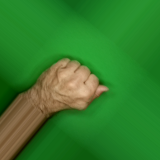
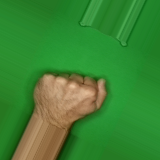
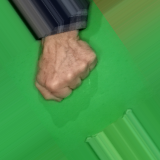
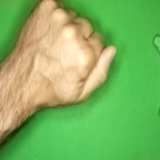
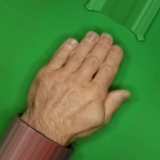
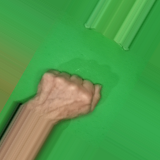

In [27]:
plot_random_images(X_train_aug, 6)

Augmented train data type: Array{Float32, 3}
Output label:              Bool[0, 0, 1]
From categories:           ["paper", "rock", "scissors"]



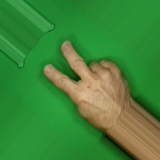

In [28]:
using ImageCore
sample_number = 50
println("Augmented train data type: $(typeof(X_train_aug[:,:,:,sample_number]))")
println("Output label:              $(y_train_one_hot[:,sample_number])")
println("From categories:           $(categories)")
println()
ImageCore.colorview(RGB, permutedims(X_train_aug[:,:,:,sample_number],(3,2,1)))

### Val data

,,,,,

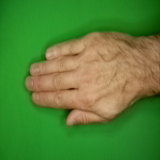
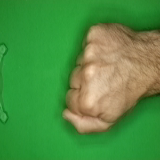
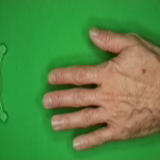
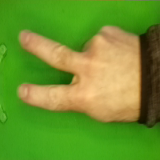
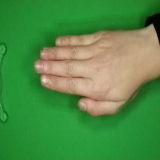
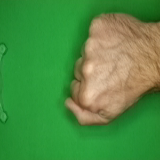

In [29]:
plot_random_images(X_val_aug, 6)

Augmented train data type: Array{Float32, 3}
Output label:              Bool[1, 0, 0]
From categories:           ["paper", "rock", "scissors"]



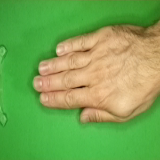

In [30]:
using ImageCore
sample_number = 50
println("Augmented train data type: $(typeof(X_val_aug[:,:,:,sample_number]))")
println("Output label:              $(y_val_one_hot[:,sample_number])")
println("From categories:           $(categories)")
println()
ImageCore.colorview(RGB, permutedims(X_val_aug[:,:,:,sample_number],(3,2,1)))

# Prepare and batch data ready for input into the model

In [31]:
using Flux
train_batches = Flux.DataLoader((X_train_aug, y_train_one_hot), batchsize=BATCH_SIZE, shuffle=false)

15-element DataLoader(::Tuple{Array{Float32, 4}, OneHotMatrix{UInt32, Vector{UInt32}}}, batchsize=32)
  with first element:
  (160×160×3×32 Array{Float32, 4}, 3×32 OneHotMatrix(::Vector{UInt32}) with eltype Bool,)

In [32]:
using Flux
val_batches = Flux.DataLoader((X_val_aug, y_val_one_hot), batchsize=BATCH_SIZE, shuffle=false)

4-element DataLoader(::Tuple{Array{Float32, 4}, OneHotMatrix{UInt32, Vector{UInt32}}}, batchsize=32)
  with first element:
  (160×160×3×32 Array{Float32, 4}, 3×32 OneHotMatrix(::Vector{UInt32}) with eltype Bool,)

# Define the model

At the end of the "chain" you can see that it is assigned to the cpu. You do not need to include this. If omitted it will work exactly the same.

However, to use a GPU you would need to change "cpu" to "gpu", and it would need to be included. I have included it just to aid in switching to GPU should you wish to do so. 

In [33]:
using Flux
# set whether to use the cpu or gpu for calculations
calc_device = cpu

(width, height, channels, records) = size(X_train_aug)

model = Flux.Chain(Flux.Conv((3, 3), channels=>32, pad=(1,1), selu),
                   Flux.MaxPool((2, 2)),
                   Flux.Conv((3, 3), 32=>64,pad=(1,1), selu),
                   Flux.MaxPool((2, 2)),
                   Flux.Conv((3, 3), 64=>64,pad=(1,1), selu),
                   Flux.MaxPool((2, 2)),
                   Flux.GlobalMeanPool(),
                   Flux.flatten,
                   Flux.Dense(64,64, selu),
                   Flux.Dense(64,3)) |> calc_device

Chain(
  Conv((3, 3), 3 => 32, selu, pad=1),   # 896 parameters
  MaxPool((2, 2)),
  Conv((3, 3), 32 => 64, selu, pad=1),  # 18_496 parameters
  MaxPool((2, 2)),
  Conv((3, 3), 64 => 64, selu, pad=1),  # 36_928 parameters
  MaxPool((2, 2)),
  GlobalMeanPool(),
  Flux.flatten,
  Dense(64 => 64, selu),                # 4_160 parameters
  Dense(64 => 3),                       # 195 parameters
)                   # Total: 10 arrays, 60_675 parameters, 2.297 KiB.

# Define loss function and any other metrics

You may note in the definition of the model that there is no softmax layer defined. This is due to the fact that it is not required.

If (for a multi-class classification problem) you use 'logitcrossentropy' for the loss, then it is not necessary to use softmax as it already has the funcitonality built in. The equivalent would be using 'crossentropy' along with softmax in the model.

However, it should be noted that it is recommended to use 'logitcrossentropy' as it is ['more numerically stable than using functions crossentropy and softmax separately.'](https://fluxml.ai/Flux.jl/stable/models/losses/#Flux.Losses.logitcrossentropy)

In [34]:
using Statistics, Flux
loss(X, y) = Flux.Losses.logitcrossentropy(model(X), y)
accuracy(X, y) = Statistics.mean(Flux.onecold(model(X)) .== Flux.onecold(y))

accuracy (generic function with 1 method)

# Define the optimiser

In [35]:
using Flux
opt = Flux.Optimise.ADAM(0.001)

Adam(0.001, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}())

# Define the training loop

There is a much simpler way of training using Julia using the train function, which is very similar to using "model.fit" in Tensorflow:

```Julia
for epoch in 1:10
    Flux.train!(loss, Flux.params(model), train_batches, opt)
end
```

However, using the above method can cause problems when dealing with large amounts of data (like images), as it requires loading all of the train data into memory.

The following function therefore allows the batches to be loaded onto the gpu (or memory for a cpu run) batch by batch. It also prints the training loss and accuracy (an average over all batches), and the validation loss on the whole validation dataset. 

**Note:** If the validation set is quite large you could also calculate the validation loss/accuracy on a batch by batch basis to save memory.

In [36]:
using Flux
function train_model(dataloader, num_epochs::Int, model, optimiser, val_data, val_labels, device)

    num_batches = length(dataloader)
    
    for epoch in 1:num_epochs

        batch_loss = 0.0
        batch_acc = 0.0

        for (count, (batch_data, batch_labels)) in enumerate(dataloader)

            # assign each batch to the device
            x, y = device(batch_data), device(batch_labels)
            gradients = Flux.gradient(() -> loss(x, y), Flux.params(model))
            Flux.Optimise.update!(optimiser, Flux.params(model), gradients)

            # collect the loss and accuracy from each batch
            batch_loss += loss(x, y)
            batch_acc += accuracy(x, y)

            # output the loss and accuracy at the end of each epoch
            if num_batches == count
                println("Epoch: $(epoch)")
                # calculate the average loss/accuracy for each epoch from the collected batches
                print("Training Loss: $(round((batch_loss / num_batches), digits=2)) ")
                print("Training Acc: $(round((batch_acc / num_batches), digits=2)) ")
                # calculate the validation loss/accuracy on the whole validation set
                print("Validation Loss: $(round(loss(device(val_data), device(val_labels)), digits=2)) ")
                print("Validation Acc: $(round(accuracy(device(val_data), device(val_labels)), digits=2))")
                println()
            end
        end
    end
end

train_model (generic function with 1 method)

# Train the model

In [37]:
train_model(train_batches, 20, model, opt, X_val_aug, y_val_one_hot, calc_device)

Epoch: 1
Training Loss: 1.18 Training Acc: 0.38 Validation Loss: 1.13 Validation Acc: 0.51
Epoch: 2
Training Loss: 1.07 Training Acc: 0.43 Validation Loss: 1.04 Validation Acc: 0.42
Epoch: 3
Training Loss: 1.03 Training Acc: 0.47 Validation Loss: 0.98 Validation Acc: 0.48
Epoch: 4
Training Loss: 1.02 Training Acc: 0.45 Validation Loss: 0.96 Validation Acc: 0.5
Epoch: 5
Training Loss: 1.01 Training Acc: 0.47 Validation Loss: 0.97 Validation Acc: 0.48
Epoch: 6
Training Loss: 0.99 Training Acc: 0.51 Validation Loss: 0.96 Validation Acc: 0.49
Epoch: 7
Training Loss: 0.99 Training Acc: 0.49 Validation Loss: 0.94 Validation Acc: 0.56
Epoch: 8
Training Loss: 0.98 Training Acc: 0.52 Validation Loss: 0.95 Validation Acc: 0.49
Epoch: 9
Training Loss: 0.97 Training Acc: 0.51 Validation Loss: 0.93 Validation Acc: 0.52
Epoch: 10
Training Loss: 0.96 Training Acc: 0.53 Validation Loss: 0.93 Validation Acc: 0.53
Epoch: 11
Training Loss: 0.94 Training Acc: 0.55 Validation Loss: 0.92 Validation Acc: 0.5